# Data Validation & CFG Pair Inspection

Validates the CSV dataset generated from Boa (`job-*.csv`), checks:
- PRE/POST balance
- CFG parseability (DOT format)
- Sample method-level pairing

Based on data in `../assets/data-samples/`

In [233]:
import pandas as pd
import os
import re
from IPython.display import display, SVG
import graphviz
import warnings
warnings.filterwarnings('ignore', category=pd.errors.ParserWarning)

In [234]:
data_dir = "../assets/data-samples/"
csv_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]
print(f"Found {len(csv_files)} CSV files:")
for f in sorted(csv_files):
    size_mb = os.path.getsize(os.path.join(data_dir, f)) / (1024**2)
    print(f"  - {f} ({size_mb:.1f} MB)")

Found 3 CSV files:
  - job-113755.csv (1101.0 MB)
  - job-113756.csv (95.6 MB)
  - job-113757.csv (1.2 MB)


In [235]:
# Load smallest sample (or prompt for job ID)
if csv_files:
    sample_file = min(csv_files, key=lambda f: os.path.getsize(os.path.join(data_dir, f)))
    df = pd.read_csv(os.path.join(data_dir, sample_file))
    print(f"✓ Loaded {len(df)} rows from {sample_file}")
else:
    raise FileNotFoundError("No CSV files found in assets/data-samples/")

✓ Loaded 999 rows from job-113757.csv


In [236]:
# Display basic info
print("\n=== Data Information ===")
print(df.info())
print(df.head())

def is_effectively_empty(series):
    # For object columns: check if all are null, empty, or whitespace-only
    if series.dtype == 'object':
        stripped = series.astype(str).str.strip()
        return stripped.isnull().all() or (stripped == '').all()
    else:
        # For non-object (e.g., float), just check all null
        return series.isnull().all()

# Remove effectively empty columns
cols_to_drop = [col for col in df.columns if is_effectively_empty(df[col])]
if cols_to_drop:
    print(f"Removing effectively empty columns: {cols_to_drop}")
    df = df.drop(columns=cols_to_drop)




# Check for malformed cfg_state
invalid_states = df[~df['cfg_state'].isin(['PRE', 'POST'])]
if len(invalid_states) > 0:
    print(f"{len(invalid_states)} rows with invalid cfg_state (e.g. blank/NaN)")


=== Data Information ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   project_name           999 non-null    object 
 1   project_description    999 non-null    object 
 2   project_url            999 non-null    object 
 3   project_creation_date  999 non-null    object 
 4   project_database       0 non-null      float64
 5   project_interfaces     0 non-null      float64
 6   project_oss            0 non-null      float64
 7   project_languages      999 non-null    object 
 8   project_topics         0 non-null      float64
 9   commit_url             999 non-null    object 
 10  files_changed_count    999 non-null    int64  
 11  commit_message         999 non-null    object 
 12  file_path              999 non-null    object 
 13  method_name            999 non-null    object 
 14  cfg_dot                999 non-n

In [237]:
# Validate PRE/POST pairing
def is_interesting_method(name: str) -> bool:
    # Exclude constructors, getters, trivial methods
    return (
        name not in {'<init>', '<clinit>'} 
        and not name.startswith('get') 
        and not name.startswith('set')
        and not name.startswith('is')   # e.g., isEmpty()
        and len(name) > 3  # skip super-short names like "run", "do"
        and not re.match(r'^[_a-z]+$', name)  # prefer camelCase (common in Java methods)
    )

In [238]:
# Apply filter to df before pairing analysis
df_interesting = df[df['method_name'].apply(is_interesting_method)].copy()

# Now recompute pairing on filtered data
pair_key = ['commit_url', 'file_path', 'method_name']
grouped = df_interesting.groupby(pair_key)['cfg_state'].apply(set).reset_index()
grouped['has_pair'] = grouped['cfg_state'].apply(lambda s: s == {'PRE', 'POST'})

paired_count = grouped['has_pair'].sum()
total_groups = len(grouped)
print(f"=== Pairing Integrity (Interesting Methods Only) ===")
print(f"- {paired_count:,} / {total_groups:,} method-commit groups have both PRE & POST")
print(f"- Pairing rate: {100 * paired_count / total_groups:.1f}%")


=== Pairing Integrity (Interesting Methods Only) ===
- 159 / 348 method-commit groups have both PRE & POST
- Pairing rate: 45.7%


In [239]:
import pandas as pd
import numpy as np
import pydot

# Optional: progress bar (install with `pip install tqdm`)
from tqdm import tqdm
tqdm.pandas()

# --- 1. Define robust node/edge counter ---
def count_nodes_edges(dot_str):
    if pd.isna(dot_str) or not isinstance(dot_str, str) or not dot_str.strip():
        return pd.Series([np.nan, np.nan], index=['node_count', 'edge_count'])
    
    # Safety: skip extremely large DOTs (likely malformed or pathological)
    if len(dot_str) > 200_000:  # >200 KB → unlikely for real CFGs
        return pd.Series([np.nan, np.nan], index=['node_count', 'edge_count'])

    try:
        # Ensure valid digraph syntax
        if 'digraph' not in dot_str:
            dot_str = f'digraph G {{\n{dot_str}\n}}'
        
        graphs = pydot.graph_from_dot_data(dot_str)
        if not graphs:
            return pd.Series([np.nan, np.nan], index=['node_count', 'edge_count'])
        g = graphs[0]

        # Filter out meta-nodes like 'node' and 'edge' (default attribute blocks)
        real_nodes = [
            n for n in g.get_nodes()
            if n.get_name() and n.get_name().strip('"') not in {'node', 'edge', ''}
        ]
        node_count = len(real_nodes)
        edge_count = len(g.get_edges())

        return pd.Series([node_count, edge_count], index=['node_count', 'edge_count'])

    except Exception as e:
        # Optional: log or collect errors separately
        # print(f"Parse error: {type(e).__name__}: {str(e)[:80]}")
        return pd.Series([np.nan, np.nan], index=['node_count', 'edge_count'])

# --- 2. Create new analysis DataFrame ---
# Select only rows with non-null, non-empty cfg_dot
cfg_df = df[df['cfg_dot'].notna() & df['cfg_dot'].astype(str).str.strip().astype(bool)].copy()

print(f"Starting with {len(cfg_df)} rows with non-empty cfg_dot (out of {len(df)})")

# --- 3. Compute metrics ---
print("Parsing CFGs and counting nodes/edges...")
metrics = cfg_df['cfg_dot'].progress_apply(count_nodes_edges)  # or .apply() without tqdm
cfg_df = pd.concat([cfg_df.reset_index(drop=True), metrics.reset_index(drop=True)], axis=1)

# --- 4. Drop rows where parsing failed (NaN counts) ---
initial_len = len(cfg_df)
cfg_df = cfg_df.dropna(subset=['node_count', 'edge_count'])
cfg_df[['node_count', 'edge_count']] = cfg_df[['node_count', 'edge_count']].astype(int)

print(f"Parsed successfully: {len(cfg_df)} CFGs ({len(cfg_df)/initial_len:.1%} success rate)")

# Optional: Add derived metrics
cfg_df['avg_edges_per_node'] = (cfg_df['edge_count'] / cfg_df['node_count']).round(2)
cfg_df['is_cyclic'] = cfg_df['edge_count'] >= cfg_df['node_count']  # naive proxy


Starting with 999 rows with non-empty cfg_dot (out of 999)
Parsing CFGs and counting nodes/edges...


100%|██████████| 999/999 [00:15<00:00, 63.76it/s]

Parsed successfully: 999 CFGs (100.0% success rate)


In [240]:
if paired_count > 0:
    # Find first pair *with structural change* (Δ nodes or edges ≠ 0)
    # First, compute metrics on df_interesting
    df_interesting[['node_count', 'edge_count']] = df_interesting['cfg_dot'].apply(
        lambda x: pd.Series(count_nodes_edges(x))
    )
    
    # Merge metrics back & find changed pairs
    pair_subset = grouped[grouped['has_pair']][pair_key].drop(
        columns=['node_count', 'edge_count'], errors='ignore'
    )
    merged = df_interesting.merge(pair_subset, on=pair_key, how='inner')
    
    # Group by method and check for Δ
    def has_change(group):
        # Expect at most 2 rows: PRE and POST
        if len(group) < 2:
            return False
        pre_row = group[group['cfg_state'] == 'PRE']
        post_row = group[group['cfg_state'] == 'POST']
        if pre_row.empty or post_row.empty:
            return False
        pre_n, pre_e = pre_row.iloc[0]['node_count'], pre_row.iloc[0]['edge_count']
        post_n, post_e = post_row.iloc[0]['node_count'], post_row.iloc[0]['edge_count']
        return (pre_n != post_n) or (pre_e != post_e)

    # Changed pairs
    changed_pairs = merged.groupby(pair_key).filter(has_change)
    
    if len(changed_pairs) > 0:
        # Pick first *changed* pair
        first_changed = changed_pairs.iloc[0]
        sample_pair = df_interesting[
            (df_interesting['commit_url'] == first_changed['commit_url']) &
            (df_interesting['file_path'] == first_changed['file_path']) &
            (df_interesting['method_name'] == first_changed['method_name'])
        ][['commit_url', 'file_path', 'method_name', 'cfg_state', 'cfg_dot', 'node_count', 'edge_count']]
        print("--- Sample CHANGED Pair (Structural Diff Detected) ---")
    else:
        # Fallback: just pick first interesting pair
        first_paired = grouped[grouped['has_pair']].iloc[0]
        sample_pair = df_interesting[
            (df_interesting['commit_url'] == first_paired['commit_url']) &
            (df_interesting['file_path'] == first_paired['file_path']) &
            (df_interesting['method_name'] == first_paired['method_name'])
        ][['commit_url', 'file_path', 'method_name', 'cfg_state', 'cfg_dot', 'node_count', 'edge_count']]
        print("--- Sample Pair (No structural change, but method is interesting) ---")
    
    # Print metadata
    row0 = sample_pair.iloc[0]
    print(f"Commit URL: {row0['commit_url']}")
    print(f"File Path: {row0['file_path']}")
    print(f"Method: {row0['method_name']}")
    print(f"Node/Edge counts:\n{sample_pair[['cfg_state','node_count','edge_count']].to_string(index=False)}")
    display(sample_pair[['cfg_state', 'cfg_dot']].head())

--- Sample CHANGED Pair (Structural Diff Detected) ---
Commit URL: https://github.com/mibto/mez/commit/6d61269dd46d3d21815f5b4cb535463151cbe972
File Path: src/main/java/ch/bli/mez/model/dao/MissionDAO.java
Method: addMission
Node/Edge counts:
cfg_state  node_count  edge_count
      PRE           9           9
     POST          10          10


,cfg_state,cfg_dot
40,PRE,digraph { \t{ rank = source; 0; } \t{ rank = s...
41,POST,digraph { \t{ rank = source; 0; } \t{ rank = s...



CFG Complexity Summary (by cfg_state)
           count  node_mean  node_median  node_max  edge_mean  edge_median  \
cfg_state                                                                    
POST         709        6.3          4.0        89        5.7          3.0   
PRE          290        6.6          5.0        50        6.1          4.0   

           edge_max  
cfg_state            
POST             88  
PRE              49  


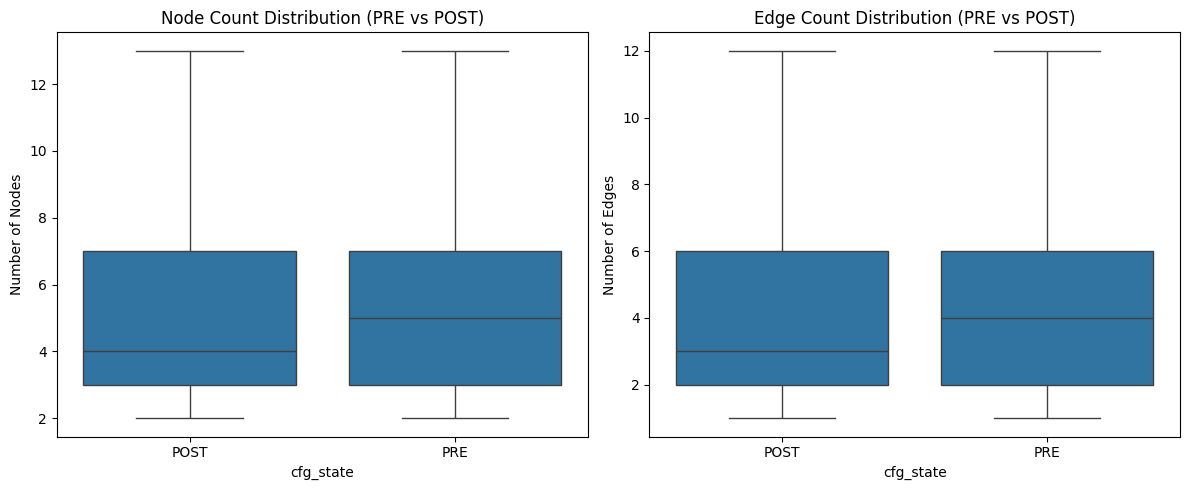

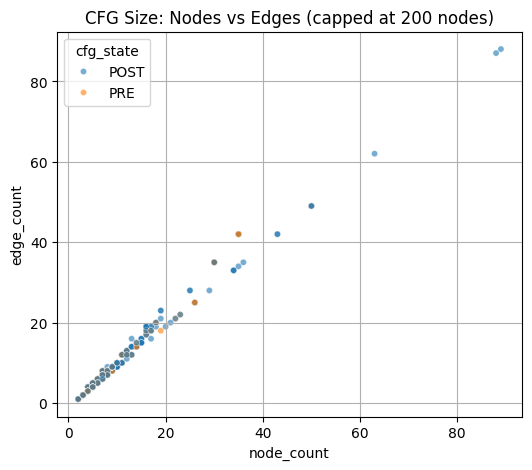

In [241]:
# === Summary Stats ===
print("\n" + "="*50)
print("CFG Complexity Summary (by cfg_state)")
print("="*50)
summary = cfg_df.groupby('cfg_state').agg(
    count=('node_count', 'size'),
    node_mean=('node_count', 'mean'),
    node_median=('node_count', 'median'),
    node_max=('node_count', 'max'),
    edge_mean=('edge_count', 'mean'),
    edge_median=('edge_count', 'median'),
    edge_max=('edge_count', 'max')
).round(1)

print(summary)

# === Visualizations (requires matplotlib/seaborn) ===
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

# Nodes
plt.subplot(1, 2, 1)
sns.boxplot(data=cfg_df, x='cfg_state', y='node_count', showfliers=False)
plt.title('Node Count Distribution (PRE vs POST)')
plt.ylabel('Number of Nodes')

# Edges
plt.subplot(1, 2, 2)
sns.boxplot(data=cfg_df, x='cfg_state', y='edge_count', showfliers=False)
plt.title('Edge Count Distribution (PRE vs POST)')
plt.ylabel('Number of Edges')

plt.tight_layout()
plt.show()

# Optional: Scatter (nodes vs edges), colored by state
plt.figure(figsize=(6,5))
sns.scatterplot(
    data=cfg_df[cfg_df['node_count'] <= 200],  # cap for readability
    x='node_count', y='edge_count', hue='cfg_state', alpha=0.6, s=20
)
plt.title('CFG Size: Nodes vs Edges (capped at 200 nodes)')
plt.grid(True)
plt.show()

In [242]:
import re

def normalize_dot(dot_str):
    """Replace all node IDs like [123] with [N0], [N1], ... in order of appearance"""
    if not isinstance(dot_str, str):
        return ""
    # Extract all node IDs (e.g., [42], n1, "entry") — Boa typically uses [num]
    # We'll assume Boa uses [digits] as node IDs (adjust if needed)
    nodes = re.findall(r'\[(\d+)\]', dot_str)
    uniq_nodes = list(dict.fromkeys(nodes))  # preserve order, dedupe
    mapping = {old: f"N{i}" for i, old in enumerate(uniq_nodes)}
    
    # Replace each [old] with [new]
    norm = dot_str
    for old, new in mapping.items():
        norm = re.sub(rf'\[{old}\]', f'[{new}]', norm)
    
    # Also sort edges and clean whitespace for stable comparison
    lines = [line.strip() for line in norm.split(';') if line.strip()]
    lines.sort()
    return '; '.join(lines)
  


In [ ]:
# Helper: Render DOT as SVG (safe for malformed DOT)
def render_cfg(dot_str, title="CFG"):
    try:
        # Boa’s DOT may have \l line breaks → replace with \n for Graphviz
        dot_clean = re.sub(r'\\l', r'\\n', dot_str)
        dot_clean = re.sub(r'\\n\s*', r'\\n', dot_clean)
        
        # Ensure graph has a name
        if not dot_clean.strip().startswith('digraph'):
            dot_clean = 'digraph G {' + dot_clean + '}'
        
        src = graphviz.Source(dot_clean, format='svg')
        svg = src.pipe(format='svg').decode('utf-8')
        return SVG(svg)
    except Exception as e:
        return f"Failed to render CFG: {e}"

In [246]:
# Ensure required imports (add at top of notebook if not already)
try:
    import graphviz
    from IPython.display import SVG, HTML, display
except ImportError as e:
    raise ImportError(
        "Missing dependencies: pip install graphviz && (system) apt install graphviz"
    ) from e

# --- Use the improved render_cfg from previous answer (included here for completeness) ---
def render_cfg(dot_str, title="CFG", max_width="100%", max_height="400px"):
    if not dot_str or not isinstance(dot_str, str):
        return HTML(f"<div style='color:red;'><b>{title}</b>: Empty or invalid DOT</div>")

    try:
        dot_clean = dot_str.strip()
        # Fix Boa line breaks
        dot_clean = re.sub(r'\\l', r'\\n', dot_clean)
        # Remove inline comments
        dot_clean = re.sub(r'//.*', '', dot_clean)
        # Wrap in digraph if needed
        if not re.match(r'^\s*(strict\s+)?digraph', dot_clean, re.I):
            dot_clean = f'digraph G {{\n{dot_clean}\n}}'
        # Escape quotes in labels (minimal fix)
        dot_clean = re.sub(r'label="([^"]*)"', lambda m: f'label="{m.group(1).replace('"', '\\"')}"', dot_clean)

        src = graphviz.Source(dot_clean, format='svg', engine='dot')
        svg_data = src.pipe(format='svg')
        svg_str = svg_data.decode('utf-8')

        style = (
            f"max-width:{max_width}; max-height:{max_height}; "
            "overflow:auto; border:1px solid #ddd; margin:8px 0; padding:4px;"
        )
        return HTML(f'''
        <div><b>{title}</b></div>
        <div style="{style}">
            {svg_str}
        </div>
        ''')

    except Exception as e:
        snippet = repr(dot_str[:150])
        return HTML(
            f"<div style='color:#d63031;'><b>{title}</b>: Render failed<br>"
            f"<small><code>{type(e).__name__}: {str(e)[:120]}</code></small><br>"
            f"<em>Snippet:</em> <code>{snippet}</code></div>"
        )

# --- Updated visualization block ---
if 'sample_pair' in locals() and len(sample_pair) == 2:
    # Extract once, safely
    row0 = sample_pair.iloc[0]
    commit_url = row0['commit_url']
    file_path = row0['file_path']
    method_name = row0['method_name']
    
    print("Sample CFG Pair (PRE → POST)")
    print(f"Commit URL: {commit_url}")
    print(f"File Path:  {file_path}")
    print(f"Method:     {method_name}")
    print()
    
    # Safely extract PRE/POST cfg_dot
    pre_row = sample_pair[sample_pair['cfg_state'] == 'PRE']
    post_row = sample_pair[sample_pair['cfg_state'] == 'POST']
    
    if len(pre_row) == 0 or len(post_row) == 0:
        print("Missing PRE or POST CFG in sample_pair.")
    else:
        pre_cfg = pre_row['cfg_dot'].iloc[0]
        post_cfg = post_row['cfg_dot'].iloc[0]
        
        display(render_cfg(pre_cfg, f"PRE: {method_name}"))
        
        display(render_cfg(post_cfg, f"POST: {method_name}"))

        # Optional: add structural diff hint
        if pre_cfg and post_cfg:
            pre_norm = normalize_dot(pre_cfg)  # from earlier helper
            post_norm = normalize_dot(post_cfg)
            if pre_norm == post_norm:
                print("CFGs are structurally identical (after node ID normalization).")
            else:
                print("CFGs differ structurally — likely control-flow change in patch.")
else:
    print("No full PRE/POST pair found in `sample_pair`. Try:")
    print("   sample_pair = df[(df['method_name'] == 'YourMethod') & (df['cfg_dot'].notna())]")
    print("# Ensure it contains both 'PRE' and 'POST' rows")

Sample CFG Pair (PRE → POST)
Commit URL: https://github.com/mibto/mez/commit/6d61269dd46d3d21815f5b4cb535463151cbe972
File Path:  src/main/java/ch/bli/mez/model/dao/MissionDAO.java
Method:     addMission



CFGs differ structurally — likely control-flow change in patch.
